In [1]:
using Random
using Distributions
using Interpolations
using GLMakie
using StatsBase
using Polynomials

In [2]:
# Discretize space
nx = 200
Lx = 1.
dx = Lx/nx
x = Array(-Lx/2+dx/2:dx:Lx/2-dx/2);

# Discretize time
dt = 0.001;
T = 10
t = Array(0.:dt:T);

# Determine the initial condition
x0 = 0.
σ0 = 0.05
c0_dist = Normal(x0, σ0) # Lagrangian
c0 = (σ0*sqrt(2π))^-1*exp.(-0.5*((x.-x0) ./ σ0).^2) # Eulerian
c = copy(c0) .* ones((1, length(t)))

# Scale brownian motion to be consistent with diffusivity
Random.seed!(2)
d = Normal(0., sqrt(dt))
κ = 0.01
U = 0.
σ = sqrt(2. * κ);

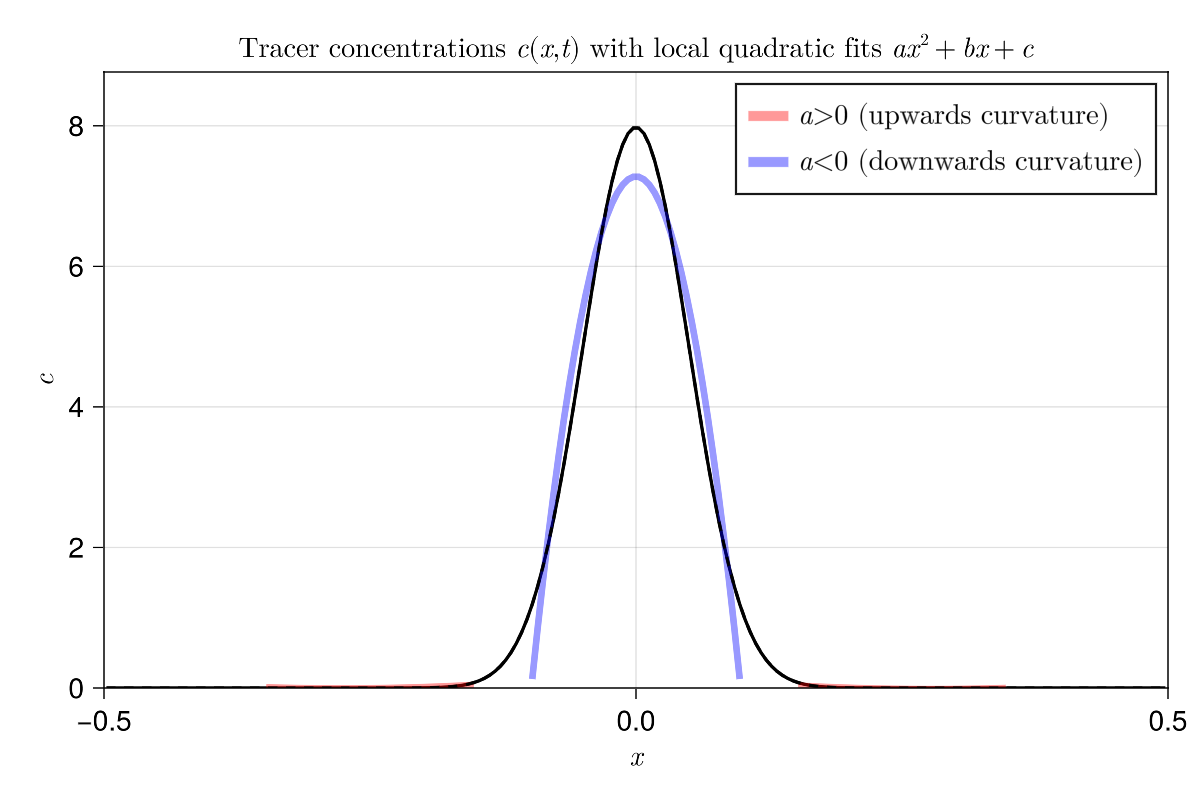

In [3]:
cp = c[:,500]

fig = Figure(size = (600, 400))
ax = Axis(
    fig[1, 1], limits=((-0.5, 0.5), (0, maximum(cp)*1.1)),
    xlabel=L"$x$", ylabel=L"$c$", title=L"Tracer concentrations $c(x,t)$ with local quadratic fits $ax^{2} + bx + c$",
)
lines!(ax, x, c[:,500], linewidth=2.5, alpha=1, color=:black)
save("../figures/Lecture05_quadratic_fits_to_tracer_concentration_00.png", fig, px_per_unit=3)

idx = -0.35 .< x .< -0.15
f = Polynomials.fit(x[idx], cp[idx], 2)
lines!(ax, x[idx], f.(x)[idx], label=L"$a > 0$ (upwards curvature)", color=:red, linewidth=5, alpha=0.4)
leg = axislegend(ax)
save("../figures/Lecture05_quadratic_fits_to_tracer_concentration_01.png", fig, px_per_unit=3)

idx = 0.15 .< x .< 0.35
f = Polynomials.fit(x[idx], cp[idx], 2)
lines!(ax, x[idx], f.(x)[idx], color=:red, linewidth=4, alpha=0.4)
delete!(leg); leg = axislegend(ax)
save("../figures/Lecture05_quadratic_fits_to_tracer_concentration_02.png", fig, px_per_unit=3)

idx = -0.1 .< x .< 0.1
f = Polynomials.fit(x[idx], cp[idx], 2)
lines!(ax, x[idx], f.(x)[idx], label=L"$a < 0$ (downwards curvature)", color=:blue, linewidth=5, alpha=0.4)
delete!(leg); leg = axislegend(ax)
save("../figures/Lecture05_quadratic_fits_to_tracer_concentration_03.png", fig, px_per_unit=3)

lines!(ax, x, c[:,700], linewidth=1.5, alpha=1, color=:black, linestyle=:dash)
save("../figures/Lecture05_quadratic_fits_to_tracer_concentration_04.png", fig, px_per_unit=3)
fig

In [4]:
function diffuse(c)
    return dt * κ * (circshift(c, 1) .- (2. *c) .+ circshift(c, -1)) / (dx^2)
end

function integrate!(c)
    return c .+ diffuse(c)
end

integrate! (generic function with 1 method)

In [5]:
struct Particle
    x ::Array{Float64, 1}
    t ::Array{Float64, 1}
end

struct ParticleCloud
    cloud ::Array{Particle}
end

function init_cloud(c0_dist, t, np)
    xp0_vec = rand(c0_dist, np)
    
    cloud = ParticleCloud(
        [Particle(ones(size(t))*xp0, t) for xp0 in xp0_vec]
    )
end

function drift!(p, t_idx)
    p.x[t_idx] = mod((p.x[t_idx-1] + U*dt) + Lx/2, Lx) - Lx/2
end

function random_walk!(p, t_idx)
    dW = rand(d, 1)[1]
    p.x[t_idx] = mod((p.x[t_idx] + σ*dW) + Lx/2, Lx) - Lx/2
end

random_walk! (generic function with 1 method)

In [6]:
function cloud_step!(cloud::ParticleCloud, t_idx)
    for p in cloud.cloud
        drift!(p, t_idx)
        random_walk!(p, t_idx)
    end
end

cloud_step! (generic function with 1 method)

In [7]:
Nparticles = 200000
cloud = init_cloud(c0_dist, t, Nparticles);
yp = rand(length(cloud.cloud)).-0.5;

for (iter, time) in zip(Iterators.countfrom(2), t[2:end])
    c[:, iter] .= integrate!(c[:, iter-1])
    cloud_step!(cloud, iter)
end

In [12]:
xp_snap = Observable([p.x[1] for p in cloud.cloud])
c_snap = Observable(c[:,1])
p_list = [4, 17, 18, 21, 27, 34, 35]
p_obs = [Observable(NaN.*cloud.cloud[p].x) for p in p_list]

fig = Figure(size = (850, 700))
ax1 = Axis(
    fig[1, 1], limits=((-0.5, 0.5), (0, maximum(c0)*1.1)),
    xlabel=L"$x$", ylabel=L"$c$", title=L"Tracer concentrations $c(x,t)$",
)

h = hist!(ax1, xp_snap, bins=x, normalization=:pdf, label="Microscopic: Probability distribution of molecules", color=(:blue, 0.5))
l = lines!(ax1, x, c_snap, color=(:black, 1), linewidth=3, label="Macroscopic: Continuum tracer concentration")
axislegend(ax1, position=:lt, labelsize=12)

ax2 = Axis(
    fig[2, 1], limits=((-0.5, 0.5), (-0.5, 0.5)),
    xlabel=L"$x$", title=L"Visualization of microscopic molecule positions (the y-axis is random, and only exists to more clearly distinguish the particles)$$",
    ylabelvisible=false, yticksvisible=false, yticklabelsvisible=false,
)
sc = scatter!(ax2, xp_snap, yp, color=(:red, 0.4), markersize=1.)

ax3 = Axis(
    fig[3, 1], limits=((0, maximum(t)), (-0.5, 0.5)),
    xlabel=L"$t$", ylabel=L"$x_{p}$", title=L"Positions of a individual particles $x_{p}(t)$",
)
for (p, p_o) in zip(p_list, p_obs)
    lines!(ax3, t, p_o, linewidth=0.4)
end

frame_frequency = 5
record(fig, "../movies/Lecture05_diffusion_brownian_motion.mp4", 1:frame_frequency:length(t);
    framerate = 60) do iter

    xp_snap[] = [p.x[iter] for p in cloud.cloud]
    c_snap[] = c[:,iter]

    for (p, p_o) in zip(p_list, p_obs)
        xp = copy(cloud.cloud[p].x)
        idx = abs.(xp[2:end] .- xp[1:end-1]) .> 0.5
        xtmp = xp[2:end]
        xtmp[idx] .= NaN
        xp[2:end] .= xtmp
        xp[iter:end] .= NaN
        p_o[] = xp
    end
    
end

"../movies/Lecture05_diffusion_brownian_motion.mp4"

In [9]:
x_std = [std([p.x[iter] for p in cloud.cloud]) for iter in 1:length(t)÷10];

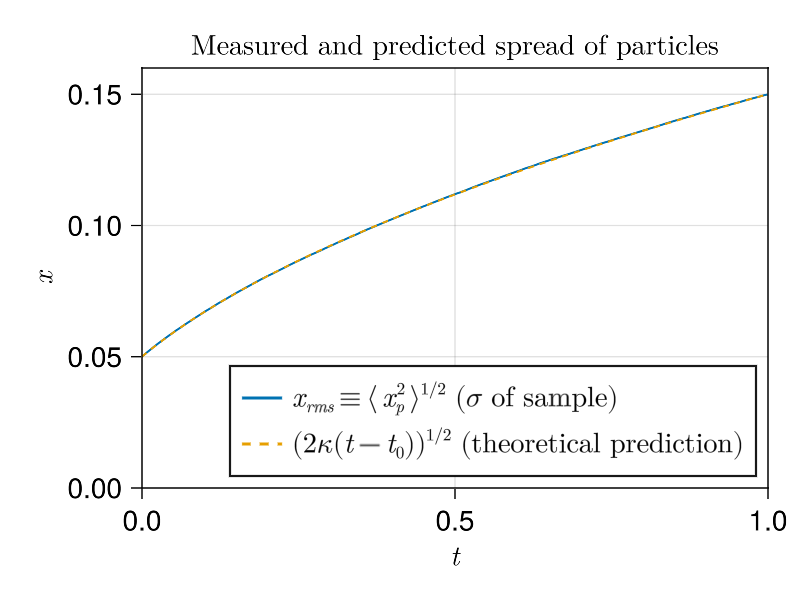

In [10]:
fig = Figure(size = (400, 300))
ax1 = Axis(
    fig[1, 1], limits=((0, maximum(t)/10), (0, 0.16)),
    xlabel=L"$t$", ylabel=L"$x$", title=L"Measured and predicted spread of particles$$",
)

lines!(t[1:length(t)÷10], x_std, label=L"$x_{rms} \equiv \langle{\,x_{p}^{2}\,\rangle}^{1/2}$ ($\sigma$ of sample)")
delete!(leg);leg = axislegend(position=:rb)
save("../figures/Lecture05_diffusive_spreading_rate_00.png", fig, px_per_unit=3)

lines!(t, sqrt.(2*κ*(t .+ x_std[1]^2/(2κ))), label=L"$(2 \kappa (t - t_{0}))^{1/2}$ (theoretical prediction)", linestyle=:dash)
delete!(leg);leg = axislegend(position=:rb)

save("../figures/Lecture05_diffusive_spreading_rate_01.png", fig, px_per_unit=3)
fig